# Data assimilation

## Biblioteka Elfi i ABC rejection algoritm

In [1]:
# import libraries
import time
import elfi
import numpy as np
import scipy.stats
import matplotlib.pyplot as plt

%matplotlib inline
%precision 2
seed = 20170530 
np.random.seed(seed)

In [2]:

# true parameters
a = 9
b = 5
#Defining size of the dataset 
how_huge_dataset = 150
x = range(how_huge_dataset)
y = [elem*a + b for elem in range(how_huge_dataset)]
all_data = np.array(x).reshape((1, len(x)))
#Defining training set
before = x[0:50]
before = np.array(before).reshape((1, len(before)))
train = x[50:100]
train = np.array(train).reshape((1, len(train)))
after = x[100:]
after = np.array(after).reshape((1, len(after)))



In [3]:
#Defining experimental Model 
def MA2(a, b, n_obs=2, batch_size=1, random_state=None):
    a = np.asanyarray(a).reshape((-1, 1))
    b = np.asanyarray(b).reshape((-1, 1))
    
    x = (np.sin((2*np.pi*a*train[:, 2:])/(23*b)) + 
     np.sin((2*np.pi*a*train[:, 2:])/28) + 
     np.sin((2*np.pi*a*train[:, 2:])/33) )* np.log(a*train[:, 2:])
    return x

#Function needed to plot and to compare observation data with simulated data
def plot_MA2(a, b, data):
    a = np.asanyarray(a).reshape((-1, 1))
    b = np.asanyarray(b).reshape((-1, 1))
    
    x = (np.sin((2*np.pi*a*data[:, 2:])/(23*b)) + 
     np.sin((2*np.pi*a*data[:, 2:])/28) + 
     np.sin((2*np.pi*a*data[:, 2:])/33) )* np.log(a*data[:, 2:])
    return x
    

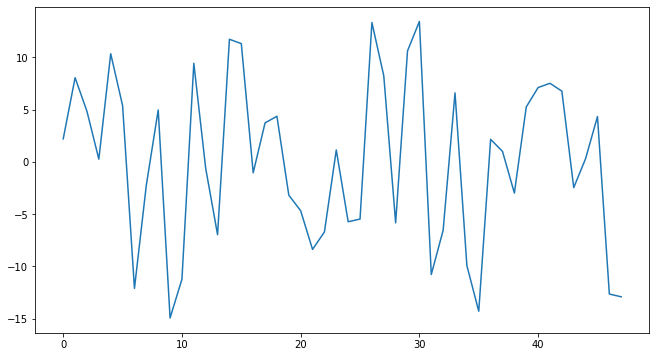

In [4]:
# Plot the observed sequence
y_obs = MA2(a, b)
plt.figure(figsize=(11, 6));
plt.plot(y_obs.ravel());

# Zmiana parametrów, zmiana wyniku

In [5]:
# a node is defined by giving a distribution from scipy.stats together with any arguments (here a-2 and 4)


# CHANGE HERE:

width = 4


a_param = elfi.Prior(scipy.stats.uniform, a-width, width)
b_param = elfi.Prior('uniform', b-width, width)


#Define the simulator node with the MA2 model ,give the priors to it as arguments.
Y = elfi.Simulator(MA2, a_param, b_param, observed=y_obs)

In [6]:
# Autocovariances as the summary statistics
def autocov(x, lag=1):
    C = np.mean(x[:,lag:] * x[:,:-lag], axis=1)
    return C

In [7]:
#Summary node is defined by giving the autocovariance function and the simulated data (also includes observed data)
S1 = elfi.Summary(autocov, Y)
S2 = elfi.Summary(autocov, Y, 2)
#Calculating the squared distance (S1_sim-S1_obs)**2 + (S2_sim-S2_obs)**2
d = elfi.Distance('euclidean', S1, S2)
#Inference with rejection sampling

# BATCH SIZE CAN BE CHANGED HERE
rej = elfi.Rejection(d, batch_size=1000, seed=seed)
# BATCH SIZE CAN BE CHANGED HERE

N = 1000
%time result = rej.sample(N, quantile=0.001)
#Print sampled means of parameters
print(result)

Progress: |██████████████████████████████████████████████████| 100.0% Complete
CPU times: user 23.1 s, sys: 1.02 s, total: 24.1 s
Wall time: 23.1 s
Method: Rejection
Number of samples: 1000
Number of simulations: 1000113
Threshold: 0.824
Sample means: a_param: 8.26, b_param: 4.14



In [8]:
#Final result of mean samples
b_result_last = result.samples['b_param'].mean()
a_result_last = result.samples['a_param'].mean()

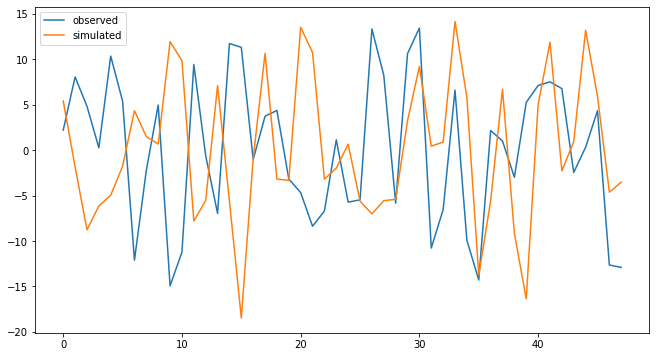

In [9]:
y_obs = MA2(a, b)
plt.figure(figsize=(11, 6));
plt.plot(y_obs.ravel(),label="observed");
plt.plot(MA2(a_result_last, b_result_last).ravel(),label="simulated");
plt.legend(loc="upper left")
plt.show()

No handles with labels found to put in legend.


<Figure size 792x432 with 0 Axes>

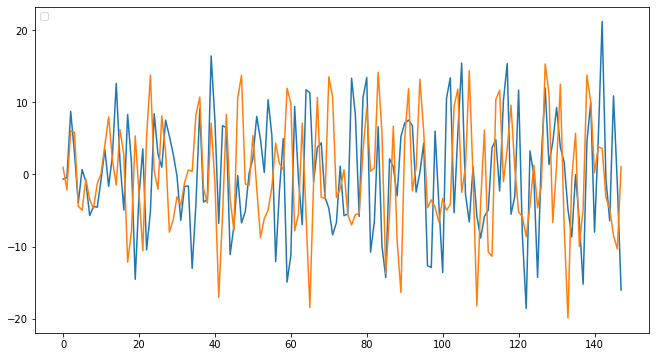

In [10]:
#Comparing observed data with simulated data on posterior parmeters (on whole data set)
plt.figure(figsize=(11, 6));
y_obs = plot_MA2(a, b, all_data)
plt.figure(figsize=(11, 6));
plt.plot(y_obs.ravel());
allq = plot_MA2(a_result_last, b_result_last, all_data)
plt.plot(allq.ravel());
plt.legend(loc="upper left")
plt.show()

In [11]:
def calculate_error(start, stop):
    calculate = 0
    for i in range(start, stop, 1):
        calculate += (y_obs[0][i] - allq[0][i])**2
    return calculate
    

In [12]:
calculate_error(100, 148)

5684.361007363609

In [13]:
calculate_error(0, 49)

3959.524713664745